In [29]:
# python
import os, pickle
from collections import OrderedDict
from pathlib import Path

# stats
import numpy as np
import pandas as pd
from scipy.stats import pearsonr


# plot
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# neural networks
import torch, torch.utils.model_zoo  # required to load nets
from torchvision.models.feature_extraction import (
    get_graph_node_names,
    create_feature_extractor,
)

# thesis library
from lib.functions_scripting import *
from lib.functions_base_analysis import *
from lib.functions_second_analysis import *
from lib.ImageDataset import ImageDataset
from lib.NetworkScorer import NetworkScorer
from lib.PatternGenerator import Pattern_Generator
from lib.ActivationPattern import Activation_Pattern
from lib.transforms import VisualPriorRepresentation
from lib.PatternGeneratorSearchlight import PatternGeneratorSearchlight


def study2behaviour(st):
    return BEHAVIOUR_NAMES[STUDY_NAMES.index(st)]


def study2dataset(st):
    if st in STUDY_NAMES[:2]:
        return DATASET_NAMES[0]
    if st == STUDY_NAMES[2]:
        return DATASET_NAMES[1]
    if st == STUDY_NAMES[3]:
        return DATASET_NAMES[2]


# storing a NetworkScorer object for saving backprojected scores
# TODO needs to be adapted when analysing multiple nets
BACKPROJECTED_SCORES_FOLDER = "./backprojected_scores"

PATH_SING_NET_RDMS = os.path.join(PATH_RESULTS, "spatial integration", "single network rdms")
PATH_SUBSETDATA = os.path.join(PATH_RESULTS, "spatial integration", "subsetdata")

In [3]:
_models = MODEL_NAMES
_studies = STUDY_NAMES
_datasets = DATASET_NAMES
_scales = SCALE_NAMES

Do for each studys:

1. For every network: RDM (imageXimage) of searchlight integration scoring. Best ibcorr-performing layer in study.

3. netXnet RDM of RDMs from (1)

# analysis

## functions

In [ ]:
def load_ibcorr_for_spatialanalysis(mo, sc):
    """ load ibcorr for one net"""
    l = []
    for st in STUDY_NAMES:
        d = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, mo, st, sc, 'ib_correlations.csv'), header=None)
        d.insert(0, 'study', st)
        d = d.reset_index().rename(columns={"index":"layer", 0:"ibcorr"})
        l.append(d)
    return pd.concat(l).reset_index(drop=True)

#setup nets for extracting activations from best layer
def setup_singlelayer(model_name: str, layer_idx: int):
    """ Setup activation extractor for a single layer of a tasnomomy network
    """
    VisualPriorRepresentation._load_unloaded_nets([model_name])
    net = VisualPriorRepresentation.feature_task_to_net[model_name]

    _, eval_nodes = get_graph_node_names(net)
    return_nodes = {node:node for node in eval_nodes if "conv" in node or 'fc' in node}
    
    layer_name = list(return_nodes.keys())[layer_idx]
    return create_feature_extractor(net, return_nodes={layer_name:layer_name}), layer_name

In [ ]:
def run_spatialintegration_analysis_bestlayer(mo, st, sc):
    # setup best-layer activation extractor
    df_ibcorr = load_ibcorr_for_spatialanalysis(mo, sc)
    best_ibcorr = (df_ibcorr
                   .iloc[df_ibcorr.groupby('study').ibcorr.idxmax(),:]
                   .set_index('study'))
    idx = best_ibcorr.loc[st].layer.astype(int)
    activation_extractor, layername = setup_singlelayer(mo, idx)

    # setup Pattern Generator
    dataset = ImageDataset(os.path.join(PATH_IMAGES, study2dataset(st), sc))
    dummy_image = next(iter(dataset))
    net_activation = activation_extractor(dummy_image[0])
    activation_shape = taskonomy_activation_layer_shapes(net_activation)
    activation_shape = torch.Size(d for d in activation_shape[layername] if d != 1)
    pat = PatternGeneratorSearchlight(activation_shape, layername)
    
    # setup storing results
    # layer x image x subset
    num_layers = 1
    num_images = dataset.img_count
    num_subsets = pat.num_subsets
    integration = np.full([num_layers,num_images,num_subsets], np.nan, dtype=np.float64)

    # run analysis
    #cnt = 0
    for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):
        #if cnt % 30 == 0: print(cnt, end= ' ')
        #cnt=cnt+1
        
        # activations as tensors
        act_full = activation_extractor(img_full)[layername].squeeze()
        act_v1 = activation_extractor(img_v1)[layername].squeeze()
        act_v2 = activation_extractor(img_v2)[layername].squeeze()
        act_avg = (act_v1 + act_v2) / 2.

        # iterate 3D positions
        pat_it = iter(pat)
        for subset_num, roi_mask in pat_it:
            
            subset_act_full = act_full[roi_mask]
            subset_act_avg = act_avg[roi_mask]

            # calculate integration and store it
            subset_integration = pearsonr(subset_act_full.flatten(), subset_act_avg.flatten())[0]
            integration[:,img_id, subset_num] = subset_integration

    return integration

### functions testing

In [ ]:
mo = 'depth_euclidean'
st = STUDY_NAMES[0]

In [ ]:
# load data
def load_ibcorr(mo, sc = SCALE_NAME):
    """ load ibcorr for one net"""
    l = []
    for st in STUDY_NAMES:
        d = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, mo, st, sc, 'ib_correlations.csv'), header=None)
        d.insert(0, 'study', st)
        d = d.reset_index().rename(columns={"index":"layer", 0:"ibcorr"})
        l.append(d)
    return pd.concat(l).reset_index(drop=True)

df_ibcorr = load_ibcorr(mo)
df_ibcorr

# visualize this: add lineplot for ibcorr of 4 studies for per net
best_ibcorr = df_ibcorr.iloc[df_ibcorr.groupby('study').ibcorr.idxmax(),:].set_index('study')
best_ibcorr

In [ ]:
#setup nets for extracting activations from best layer
def setup_singlelayer(model_name: str, layer_idx: int):
    """ Setup activation extractor for a single layer of a tasnomomy network
    """
    VisualPriorRepresentation._load_unloaded_nets([model_name])
    net = VisualPriorRepresentation.feature_task_to_net[model_name]

    _, eval_nodes = get_graph_node_names(net)
    return_nodes = {node:node for node in eval_nodes if "conv" in node or 'fc' in node}
    
    layer_name = list(return_nodes.keys())[layer_idx]
    return create_feature_extractor(net, return_nodes={layer_name:layer_name}), layer_name

idx = best_ibcorr.loc[st].layer.astype(int)
activation_extractor, layername = setup_singlelayer(mo, idx)
layername

In [ ]:
# load net and activation shape (of best layer)
dataset = ImageDataset(os.path.join(PATH_IMAGES, study2dataset(st), SCALE_NAME))
dummy_image = next(iter(dataset))
net_activation = activation_extractor(dummy_image[0])
activation_shape = taskonomy_activation_layer_shapes(net_activation)
activation_shape = torch.Size(d for d in activation_shape[layername] if d != 1)

pat = PatternGeneratorSearchlight(activation_shape, layername)

In [ ]:
# layer x image x subset
num_layers = 1
num_images = dataset.img_count
num_subsets = pat.num_subsets
integration = np.full([num_layers,num_images,num_subsets], np.nan, dtype=np.float64)

# run analysis
cnt = 0

for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):
    if cnt % 30 == 0: print(cnt, end= ' ')
    cnt=cnt+1
    
    # activations as tensors
    act_full = activation_extractor(img_full)[layername].squeeze()
    act_v1 = activation_extractor(img_v1)[layername].squeeze()
    act_v2 = activation_extractor(img_v2)[layername].squeeze()
    act_avg = (act_v1 + act_v2) / 2.

    # iterate 3D positions in layer
    pat_it = iter(pat)
    for subset_num, roi_mask in pat_it:
        
        subset_act_full = act_full[roi_mask]
        subset_act_avg = act_avg[roi_mask]

        # calculate integration and store it
        subset_integration = pearsonr(subset_act_full.flatten(), subset_act_avg.flatten())[0]
        integration[:,img_id, subset_num] = subset_integration

In [ ]:
with open(os.path.join(PATH_RESULTS, RESULTS_SEMANTIC_PLACES1, "semantic_integration.npy"), 'rb') as f:
    integration = np.load(f)

In [ ]:
# load beauty ratings
beauty_ratings = pd.read_csv(os.path.join(PATH_RATINGS, study2behaviour(st)), header=None).mean(axis=1)

# correlate integration with beauty
scores = correlate_integration_beauty(integration, beauty_ratings)

# convert integration back to 3D layer space
ns = NetworkScorer({layername:activation_shape})
ns.map_back_scores(scores, pat)

## execution

In [ ]:
# run analysis
# TODO: change to save as hdf5
_study = "complexity order"
_scale = "scale4"


for mo in MODEL_NAMES:
    print(mo)
    integration_subsets = run_spatialintegration_analysis_bestlayer(mo, _study, _scale)
    integration = pd.DataFrame(integration_subsets.squeeze().T)
    integration.to_csv(
        os.path.join(
            PATH_RESULTS,
            "spatial integration",
            _scale,
            _study + " subsetdata",
            mo + ".csv",
        )
    )

In [ ]:
# multiprocessing code

In [ ]:
# from multiprocessing import Pool
# with Pool() as pool:
#     l1 = pool.starmap(run_spatialintegration_analysis_bestlayer, zip(MODEL_NAMES[5:], ["short presentation"] * len(MODEL_NAMES[5:]), ["scale4"] * len(MODEL_NAMES[5:]))   )

#d1 = {k: d1[k] for k in _models}

# for mo, data in l1:
#     df = pd.DataFrame(data.squeeze().T)
#     calculate_rdm(df)
#     df.to_csv(os.path.join(PATH_RESULTS, "spatial integration", "scale4", "study1", mo + ".csv"))


# network imageXimage RDMs
representing spatial structure in common space across networks

In [ ]:
# calculate network RDMs from subsetdata

In [73]:
dfspi_rdms = dfspi.groupby("model").corr().groupby("model").apply(set_diagonal_to_zero)

In [6]:
# save network RDMs as hdf

In [ ]:
# load network RDMs from hdf

In [ ]:
dfspi_rdms = pd.read_hdf(
    os.path.join(
        PATH_RESULTS,
        "spatial integration",
        "single network rdms",
        "scale4 study1 allnets.h5",
    ),
    key="dfspi_rdms",
)

In [101]:
# dfspi_rdms.to_hdf(
#     os.path.join(
#         PATH_RESULTS,
#         "spatial integration",
#         _scale,
#         "rdms " + _study + " allnets.h5",
#     ),
#     key="dfspi_rdms",
# )

# predictorRDM

"how"
"where" or alternatively "what",  which is the same because its spatial integration. Check for correlation between the what (represented by the integration ratings).

In [93]:
dl = []
for filename in os.listdir(PATH_SING_NET_RDMS):
    scale, study, _ = Path(filename).stem.split()
    study = studyname(study)
    data = (
        pd.read_hdf(os.path.join(PATH_SING_NET_RDMS, filename))
        .assign(study=study, scale=scale)
        .set_index(["study", "scale"], append=True)
        .reorder_levels(["study", "scale", "model", "img"])
    )
    dl.append(data)

dfspi_rdms = pd.concat(dl)

In [94]:
dfspi_rdms

img                                                 0         1         2  \
study            scale  model           img                                 
complexity order scale8 autoencoding    0    0.000000  0.065853  0.268209   
                                        1    0.065853  0.000000  0.196143   
                                        2    0.268209  0.196143  0.000000   
                                        3    0.052688  0.468951  0.151871   
                                        4    0.319964  0.187701  0.152050   
...                                               ...       ...       ...   
                 scale4 vanishing_point 245  0.224843  0.246369  0.338090   
                                        246  0.555061  0.380135  0.495111   
                                        247  0.428160  0.259019  0.286163   
                                        248  0.346852  0.265879  0.371492   
                                        249  0.643557  0.458602  0.512385   

img                                                 3         4         5  \
study            scale  model           img                                 
complexity order scale8 autoencoding    0    0.052688  0.319964  0.298544   
                                        1    0.468951  0.187701  0.216722   
                                        2    0.151871  0.152050  0.241353   
                                        3    0.000000  0.105986  0.093960   
                                        4    0.105986  0.000000  0.286814   
...                                               ...       ...       ...   
                 scale4 vanishing_point 245  0.294132  0.254244  0.304206   
                                        246  0.533161  0.543601  0.464897   
                                        247  0.458115  0.398085  0.287108   
                                        248  0.433612  0.491487  0.402992   
                                        249  0.522883  0.496421  0.488303   

img                                                 6         7         8  \
study            scale  model           img                                 
complexity order scale8 autoencoding    0    0.303844  0.338253  0.080624   
                                        1    0.145107  0.207201  0.228692   
                                        2    0.492494  0.292385  0.019761   
                                        3    0.156893  0.078106  0.049101   
                                        4    0.125763  0.374823  0.168674   
...                                               ...       ...       ...   
                 scale4 vanishing_point 245  0.335670  0.348492  0.196506   
                                        246  0.531352  0.332438  0.455332   
                                        247  0.404336  0.491371  0.364493   
                                        248  0.457202  0.438148  0.237683   
                                        249  0.459728  0.366798  0.493343   

img                                                 9  ...       240  \
study            scale  model           img            ...             
complexity order scale8 autoencoding    0    0.168532  ...  0.162140   
                                        1   -0.083858  ... -0.056059   
                                        2    0.030654  ...  0.027897   
                                        3   -0.082435  ... -0.082211   
                                        4    0.219726  ...  0.261819   
...                                               ...  ...       ...   
                 scale4 vanishing_point 245  0.236015  ...  0.273163   
                                        246  0.461132  ...  0.428144   
                                        247  0.249846  ...  0.500920   
                                        248  0.304326  ...  0.581422   
                                        249  0.419848  ...  0.476658   

img                                               241    

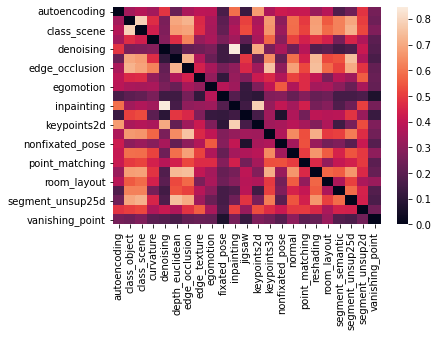

In [149]:
g_studyscale = dfspi_rdms.groupby(["study", "scale"])
l = []
for gk in g_studyscale.groups.keys():
    gss = g_studyscale.get_group(gk).groupby("model")

    rdm = pd.DataFrame(0, index=_models, columns=_models)
    for mo1, mo2 in combinations(gss.groups.keys(), 2):
        c = correlate_rdms(gss.get_group(mo1), gss.get_group(mo2))[0]
        rdm.loc[mo1, mo2], rdm.loc[mo2, mo1] = c, c
    rdm = rdm.assign(study=gk[0], scale=gk[1]).set_index(["study","scale"], append=True).reorder_levels(["study","scale",None])
    l.append(rdm)

predictor_rdm_3 = pd.concat(l)
sns.heatmap(predictor_rdm_3.loc[("short presentation","scale4")])

In [153]:
predictor_rdm_3.to_hdf(
    os.path.join(PATH_RESULTS, "spatial integration", "predictor3 bestpredlayer.hd5"),
    key="predictor_rdm_3",
)

In [ ]:
# predictor_rdm_3 = pd.DataFrame(0, index=_models, columns=_models)
# g = dfspi_rdms.groupby("model")

# for gk1, gk2 in combinations(g.groups.keys(), 2):
#     c = correlate_rdms(g.get_group(gk1), g.get_group(gk2))[0]
#     predictor_rdm_3.loc[gk1, gk2], predictor_rdm_3.loc[gk2, gk1] = c, c

# integration is localized

In [ ]:
# visualize node score distribution

In [ ]:
# visualize within layer heatmaps

# exemplars

In [ ]:
# spatial correlation per image per net, correlate these netXnet
# test if integration scores are still correlating to beauty

# old version: searchlight scoring best predicting nets

Representative net from each category:

semantic:   segment semantic \
2D:         segment unsup 2d \
3D:         depth euclidean

> from each class of networks take the one layer with highest integration beauty score across networks


In [ ]:
# load integration-beauty correlation for 3 nets
SCALE_NAME = "scale4"
MODEL_SEMANTIC = "segment_semantic"
MODEL_2D = "segment_unsup2d"
MODEL_3D = "depth_euclidean"


def load_ibcorr(m):
    l = []
    for s in STUDY_NAMES:
        d = pd.read_csv(os.path.join(PATH_IB_CORRELATIONS, m, s, SCALE_NAME, 'ib_correlations.csv'), header=None)
        d.insert(0, 'study', s)
        d = d.reset_index().rename(columns={"index":"layer", 0:"ibcorr"})
        l.append(d)
    
    return pd.concat(l).reset_index(drop=True)

df_segment_semantic = load_ibcorr(MODEL_SEMANTIC)
df_segment_unsup2d = load_ibcorr(MODEL_2D)
df_depth_euclidean = load_ibcorr(MODEL_3D)

In [ ]:
# find layers with highest integration-beauty correlation
# get scale and layer num of layer with highest correlation
best_semantic = df_segment_semantic.iloc[df_segment_semantic.ibcorr.idxmax(),:]
best_2d = df_segment_unsup2d.iloc[df_segment_unsup2d.ibcorr.idxmax(),:]
best_3d = df_depth_euclidean.iloc[df_depth_euclidean.ibcorr.idxmax(),:]
print(best_semantic)
print(best_2d)
print(best_3d)

In [ ]:
#setup nets for extracting activations from best layer
def setup_singlelayer(model_name: str, layer_idx: int):
    """ Setup activation extractor for a single layer of a tasnomomy network
    """
    VisualPriorRepresentation._load_unloaded_nets([model_name])
    net = VisualPriorRepresentation.feature_task_to_net[model_name]

    _, eval_nodes = get_graph_node_names(net)
    return_nodes = {node:node for node in eval_nodes if "conv" in node or 'fc' in node}
    
    layer_name = list(return_nodes.keys())[layer_idx]
    return create_feature_extractor(net, return_nodes={layer_name:layer_name}), layer_name

activation_extractor_semantic, layername_best_semantic = setup_singlelayer(MODEL_SEMANTIC, best_semantic.layer)
activation_extractor_2d, layername_best_2d = setup_singlelayer(MODEL_2D, best_2d.layer)
activation_extractor_3d, layername_best_3d = setup_singlelayer(MODEL_3D, best_3d.layer)

Do integration beauty scoring with node pools sweeping along 3D axis
- full width 2D layer pools along all three axis
- 3D cubic pool along all three axis (vary in size)

Effectively just need to change the PatternGenerator, and switch from iterating subset num to iterating the pattern generator

In [ ]:
RESULTS_SEMANTIC_PLACES1 = './searchlight/singlelayer'

### semantic net

semantic, places1, best layer

### load images & activation shape (semantic) 

In [ ]:
dataset = ImageDataset(os.path.join(PATH_IMAGES, "places1", best_semantic.scale))

num_images = dataset.img_count

# activation shape as Dict
dummy_image = next(iter(dataset))
net_activation = activation_extractor_semantic(dummy_image[0])
net_activation = OrderedDict(net_activation)
activation_shapes = taskonomy_activation_layer_shapes(net_activation)

# activation shape as Tensor
activation_shape_semantic = list(activation_shapes.values())[0][1:]

### single image(s)

can only map back integration-beauty score for whole dataset, however, its possible, that in every image something different gets integrated, therefore it wouldn't make sense to map back a score for the whole dataset to individual nodes.

Since we know that (at least some) integration, and subsets integration, is meaningfull, we map back integration of individual images onto individual nodes, without correlating this integration with beauty.

In [ ]:
# --- SETUP VARIABLES ---
pat_s = PatternGeneratorSearchlight(
    activation_shape_semantic,
    layername_best_semantic
    )

num_layers = 1 # only take activations of best performing layer from each net
num_images = 1
num_subsets = pat_s.num_subsets

# layer x image x subset
integration = np.full([num_layers, num_images, num_subsets], np.nan, dtype=np.float64)
cnt = 0

    
# load single image
img_id = 0
img_full, img_v1, img_v2 = next(iter(dataset))

# --- ANALYSIS ---

act_full = activation_extractor_semantic(img_full)[layername_best_semantic].squeeze()
act_v1 = activation_extractor_semantic(img_v1)[layername_best_semantic].squeeze()
act_v2 = activation_extractor_semantic(img_v2)[layername_best_semantic].squeeze()
act_avg = (act_v1 + act_v2) / 2.

# iterate 3D positions
pat_it = iter(pat_s)
for subset_num, roi_mask in pat_it:
    
    subset_act_full = act_full[roi_mask]
    subset_act_avg = act_avg[roi_mask]

    # calculate integration and store it
    subset_integration = -pearsonr(subset_act_full.flatten(), subset_act_avg.flatten())[0]
    integration[:,img_id, subset_num] = subset_integration

In [ ]:
integration = integration.squeeze(0)
integration.shape

In [ ]:
activation_shapes['layer3.4.conv2'] = activation_shape_semantic
ns = NetworkScorer(activation_shapes)
ns.map_back_scores(integration, pat_s)


### score all images

In [ ]:
# layer x image x subset
integration = np.full([num_layers,num_images,num_subsets], np.nan, dtype=np.float64)
cnt = 0

# iterate image set
for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):
    if cnt % 30 == 0: print(cnt, end= ' ')
    cnt=cnt+1
    
    # activations as tensors
    act_full = activation_extractor_semantic(img_full)[layername_best_semantic].squeeze()
    act_v1 = activation_extractor_semantic(img_v1)[layername_best_semantic].squeeze()
    act_v2 = activation_extractor_semantic(img_v2)[layername_best_semantic].squeeze()
    act_avg = (act_v1 + act_v2) / 2.

    # iterate 3D positions in layer
    pat_it = iter(pat_s)

    for subset_num, roi_mask in pat_it:
        
        subset_act_full = act_full[roi_mask]
        subset_act_avg = act_avg[roi_mask]

        # calculate integration and store it
        subset_integration = pearsonr(subset_act_full.flatten(), subset_act_avg.flatten())[0]
        integration[:,img_id, subset_num] = subset_integration

In [ ]:
with open(os.path.join(PATH_RESULTS, RESULTS_SEMANTIC_PLACES1, "semantic_integration.npy"), "wb") as f:
    np.save(f, integration)

In [ ]:
with open(os.path.join(PATH_RESULTS, RESULTS_SEMANTIC_PLACES1, "semantic_integration.npy"), 'rb') as f:
    integration = np.load(f)

In [ ]:
integration.shape

In [ ]:
# load beauty ratings
beauty_ratings = ImageDataset(
    os.path.join(DATA_PATH, DATASET_NAMES[0], SCALE_NAMES[0]),
    beauty_ratings_path='behavior/ratings_study1.csv').beauty_ratings

# correlate integration with beauty
scores = correlate_integration_beauty(integration, beauty_ratings)

In [ ]:
# convert integration back to 3D layer space
activation_shapes['layer3.4.conv2'] = activation_shape_semantic
ns = NetworkScorer(activation_shapes)
ns.map_back_scores(scores, pat_s)

## Visualize spatial integration

## score distribution

In [ ]:
# TODO plot all heatmaps with the same absoloute color scale
with PdfPages('integration heatmap semantic img0.pdf') as pdf:
    for vertical_slice in ns.scores[layername_best_semantic].squeeze():
        sns.heatmap(vertical_slice)
        pdf.savefig()
        plt.close() 

In [ ]:
t = ns.scores[layername_best_semantic]
t.min(), t.max()

In [ ]:
t = t.flatten()
num_bins = 30
hist = torch.histc(t, bins=num_bins, min=torch.min(t).item(), max=torch.max(t).item())

# Define the edges of the bins
bin_edges = torch.linspace(torch.min(t).item(), torch.max(t).item(), steps=num_bins + 1)

# Plot the histogram using Matplotlib
plt.figure(figsize=(8, 6))
plt.hist(t.numpy(), bins=bin_edges.numpy(), edgecolor='black')
plt.title('Histogram of Tensor Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()


## Integration heatmap

In [ ]:
inte = ns.scores[layername_best_semantic].squeeze()

# plot only highest integrating nodes
with PdfPages('integration heatmap semantic img0 best.pdf') as pdf:
    for vertical_slice in inte:
        sns.heatmap(vertical_slice)
        pdf.savefig()
        plt.close() 

## Permutation testing

Repeat analysis for randomly shuffeled integration values

In [ ]:

integration = integration.squeeze(0)
integration.shape

In [ ]:
integration_pt = torch.tensor(integration)

In [ ]:
integration_pt.nelement()

In [ ]:
integration_randomized = integration_pt[torch.randperm(integration_pt.nelement())]

In [ ]:
integration.shape

In [ ]:
integration_randomized.shape

In [ ]:
ns = NetworkScorer(activation_shapes)
ns.map_back_scores(integration_randomized.unsqueeze(0), pat_s)


In [ ]:
# plot random pattern heatmaps for visual comparison
# TODO generate permutation distribution
with PdfPages('integration heatmap random scores.pdf') as pdf:
    for vertical_slice in ns.scores[layername_best_semantic]:
        sns.heatmap(vertical_slice)
        pdf.savefig()
        plt.close() 

In [ ]:
activation_shapes["layer2.3.conv1"]

# Are integration beauty scores meaningfull ?

- Do the top nodes integration predict beauty better than the bottom nodes (or any other random 10%) ? \
- Use spatially coherent subsets to calculate scores.

# random pattern scoring

In [ ]:
def run_singlelayer_analysis(dataset, activation_extractor, num_subsets, frac):
    num_layers = 1 # only take activations of best performing layer from each net
    num_images = dataset.img_count

    # get shapes of activation
    dummy_image = next(iter(dataset))
    net_activation = activation_extractor(dummy_image[0])
    net_activation = OrderedDict(net_activation)
    activation_shapes = taskonomy_activation_layer_shapes(net_activation)
    
    pat = Pattern_Generator(
        num_subsets,
        activation_shapes,
        frac=frac
        )

    # layer x image x subset
    integration = np.full([num_layers,num_images,num_subsets], np.nan, dtype=np.float64)
    cnt = 0

    # iterate image set
    for img_id, (img_full, img_v1, img_v2) in enumerate(iter(dataset)):
        if cnt % 30 == 0: print(cnt, end= ' ')
        cnt=cnt+1
        
        act_full = Activation_Pattern(activation_extractor(img_full))
        act_v1 = Activation_Pattern(activation_extractor(img_v1))
        act_v2 = Activation_Pattern(activation_extractor(img_v2))
        act_avg = Activation_Pattern.average(act_v1, act_v2)

        # iterate node subsets
        for subset_num in range(num_subsets):
            subset_mask = pat.get_subset_pattern(subset_num)
            
            subset_act_full = act_full[subset_mask]
            subset_act_avg = act_avg[subset_mask]

            # calculate integration and store it
            subset_integration = Activation_Pattern.calculate_integration_coeff(subset_act_full, subset_act_avg)
            integration[:,img_id, subset_num] = subset_integration
    
    ns = NetworkScorer(activation_shapes)
    ns.map_back_scores(integration, pat)

    return integration, ns

In [ ]:
num_subsets = 10000
# run analysis for semantic
dataset = ImageDataset(os.path.join(DATA_PATH, "places1", best_semantic.scale))

integration_semantic_frac01, ns_semantic_frac01 = run_singlelayer_analysis(
    dataset,
    activation_extractor_semantic,
    num_subsets,
    frac=0.01
    )

integration_semantic_frac10, ns_semantic_frac10 = run_singlelayer_analysis(
    dataset,
    activation_extractor_semantic,
    num_subsets,
    frac=0.10
    )

integration_semantic_frac90, ns_semantic_frac90= run_singlelayer_analysis(
    dataset,
    activation_extractor_semantic,
    num_subsets,
    frac=0.90
    )

In [ ]:
integration_semantic_frac01.shape, ns_semantic_frac01.scores['layer3.4.conv2'].shape

In [ ]:
type(integration_semantic_frac01), type(ns_semantic_frac01.scores['layer3.4.conv2'])

In [ ]:
num_subsets = 10000

# run analysis for semantic
dataset = ImageDataset(os.path.join(DATA_PATH, "places1", best_semantic.scale))

integration_semantic_frac01, ns_semantic_frac01 = run_singlelayer_analysis(
    dataset,
    activation_extractor_semantic,
    num_subsets,
    frac=0.01
    )

integration_semantic_frac10, ns_semantic_frac10 = run_singlelayer_analysis(
    dataset,
    activation_extractor_semantic,
    num_subsets,
    frac=0.10
    )

integration_semantic_frac90, ns_semantic_frac90= run_singlelayer_analysis(
    dataset,
    activation_extractor_semantic,
    num_subsets,
    frac=0.90
    )

# run analysis for 2d
dataset = ImageDataset(os.path.join(DATA_PATH, "places1", best_2d.scale))

integration_2d_frac01, ns_2d_frac01 = run_singlelayer_analysis(
    dataset,
    activation_extractor_2d,
    num_subsets,
    frac=0.01
    )

integration_2d_frac10, ns_2d_frac10 = run_singlelayer_analysis(
    dataset,
    activation_extractor_2d,
    num_subsets,
    frac=0.10
    )

integration_2d_frac90, ns_2d_frac90= run_singlelayer_analysis(
    dataset,
    activation_extractor_2d,
    num_subsets,
    frac=0.90
    )

# run analysis for 3d
dataset = ImageDataset(os.path.join(DATA_PATH, "places1", best_3d.scale))

integration_3d_frac01, ns_3d_frac01 = run_singlelayer_analysis(
    dataset,
    activation_extractor_3d,
    num_subsets,
    frac=0.01
    )

integration_3d_frac10, ns_3d_frac10 = run_singlelayer_analysis(
    dataset,
    activation_extractor_3d,
    num_subsets,
    frac=0.10
    )

integration_3d_frac90, ns_3d_frac90= run_singlelayer_analysis(
    dataset,
    activation_extractor_3d,
    num_subsets,
    frac=0.90
    )

### save results

In [ ]:
FOLDER_SINGLELAYER_ANALYSIS = './analysis results singlelayer'

In [ ]:
from itertools import product
files_i = ["integration"+netclass+fracsize+".npy"
           for netclass, fracsize
           in product(["_semantic","_2d","_3d"], ["_frac01","_frac10","_frac90"])]
files_i

In [ ]:
files_n = ["integration"+netclass+fracsize+".pkl"
           for netclass, fracsize
           in product(["_semantic","_2d","_3d"], ["_frac01","_frac10","_frac90"])]
files_n

In [ ]:
arrays_integration = [integration_semantic_frac01, integration_semantic_frac10, integration_semantic_frac90,
                      integration_2d_frac01, integration_2d_frac10, integration_2d_frac90,
                      integration_3d_frac01, integration_3d_frac10, integration_3d_frac90]

objects_nodescoring = [ns_semantic_frac01, ns_semantic_frac10, ns_semantic_frac90,
                       ns_2d_frac01, ns_2d_frac10, ns_2d_frac90,
                       ns_3d_frac01, ns_3d_frac10, ns_3d_frac90]

In [ ]:
for file_i, file_n, array_i, array_n in zip(files_i, files_n, arrays_integration, objects_nodescoring):
    with open(os.path.join(FOLDER_SINGLELAYER_ANALYSIS, file_i), "wb") as f1:
        np.save(f1, array_i)
    
    with open(os.path.join(FOLDER_SINGLELAYER_ANALYSIS, file_n), "wb") as f2:
        pickle.dump(array_n, f2)


### load results

# manipulating integratability and watch response of network



gradually perform image transformations shown to break integration to:
- test where in the network integration takes place
- test whether different manipulations break different clusters first



Do integration beauty scoring with node pools sweeping along 3D axis
- full width 2D layer pools along all three axis
- 3D cubic pool along all three axis (vary in size)

permutation test for integration: generate permutation distribution by calculating integration at each location in the layer to random input. input real image, calculate clusters of significant integration.

Do semantic / 2d / 3d nets integrate different features (semantic vs structural) or are they essentially integrating the same features but in a different way ?

Do different manipulations break integration in different ways ?
Look at:
    a) How much manipulation does is need to break integration ?
    b) In which networks / layers / scales / datasets is integration broken in which order ?
    c) Which image's integration is broken first ?


Collect different ways of manipulating images to break integration.
    - Do these
    a) all break integration the same way
    b) cluster into groups in the way in which they break integration


### pixelated images

In [ ]:
dataset = ImageDataset(os.path.join(DATA_PATH, "places1", best_semantic.scale))
it_dataset = iter(dataset)

im = next(it_dataset)[0].squeeze()
im2 = next(it_dataset)[2].squeeze()

In [ ]:
im.min(), im.max(), im2.min(), im2.max()

In [ ]:
im = im + im.min().abs()
im = im / im.max()
#d2 = 1-d2
im.min(), im.max()

In [ ]:
plt.imshow(im.permute(1,2,0))

In [ ]:
# take a fraction of the pixels on the 256x256 grid and permute them
pix_degree = 0.5

In [ ]:
mask_pix = torch.rand((256,256)) < pix_degree
mask_original = ~mask_pix

# number of pixels that are pixeled, this is not exactly the pix degree due to randomness
n_pix = im[:,mask_pix].shape[1] 


In [ ]:
pix_im = torch.full_like(im, np.nan)

# non-pixeled part
pix_im[:,mask_original] = im[:,mask_original]

# pixeled part
pix_im[:,mask_pix] = im[:,mask_pix][:,torch.randperm(n_pix)]

In [ ]:
def pixelate_image(im, pix_degree: float):
    """ Pixelate a 256x256 image"""
    mask_pix = torch.rand((256,256)) < pix_degree
    mask_original = ~mask_pix

    # number of pixels that are pixeled, this is not exactly the pix degree due to randomness
    n_pix = im[:,mask_pix].shape[1] 

    pix_im = torch.full_like(im, np.nan)

    # non-pixeled part
    pix_im[:,mask_original] = im[:,mask_original]

    # pixeled part
    pix_im[:,mask_pix] = im[:,mask_pix][:,torch.randperm(n_pix)]

    return pix_im


In [ ]:
def img_print(im):
    im = im + im.min().abs()
    im = im / im.max()
    plt.imshow(im.permute(1,2,0))

In [ ]:
img_print(pixelate_image(im, 0.01))

In [ ]:
# TODO: since at 0.25 theres already a strong (subjective) visual disturbance,
# maybe apply a logarithmic scale with image pixelation

In [ ]:
# TODO: as annother gradual transformation, implement a gradual low-pass filter

### imageversions

In [ ]:
torch.tensor(127/127.5-1, dtype=torch.float32)

In [ ]:
torch.tensor([[1,0],[0,1]]).repeat_interleave(2,dim=0).repeat_interleave(2,dim=1)

In [ ]:
def create_checkerboard(scale, size=256):
    msc = torch.tensor([[1, 0] * (scale//2), [0, 1] * (scale//2)] * (scale//2))
    return msc.repeat_interleave(size//scale, dim=0).repeat_interleave(size//scale, dim=1)

In [ ]:
create_checkerboard(64).shape

### get activations for pixelated images

In [ ]:
act_full 

In [ ]:
activation_extractor_semantic().keys()

In [ ]:
activation_extractor_semantic(torch.rand_like(dummy_image[0]))['layer3.4.conv2'].shape

###  get distribution of integration / ib-correlation of random images

In [ ]:
dummy_image[1]

In [ ]:
# for each image
ac = activation_extractor_semantic(torch.rand_like(dummy_image[0]))['layer3.4.conv2']
ac = ac.squeeze()
ac.shape

### get previous one at each location

In [ ]:
for l1, l2 in zip(ac_full, ac_avg):
    pass

In [ ]:
l1.shape

### visual inspection
are there maybe any clusters of integration to random images, already revealing a integration structure in the network

### get activation of actual image

### test where there are significant clusters of integration